That last notebook got messy so I'm making a new cleaner one that will enable me to sample over both emulators simultaneously. 

In [170]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [171]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
#from corner import corner
from ast import literal_eval
from pearce.emulator import LemonPepperWet
from os import path
from scipy.linalg import inv

In [172]:
fname = '/u/ki/swmclau2/des/PearceMCMC/HOD3_wp_ds_rmin_0.5_HOD.hdf5'

In [173]:
f = h5py.File(fname, 'r')

In [174]:
tf = f.attrs['training_file']
fixed_params = literal_eval(f.attrs['fixed_params'])
if 'rmin' in fixed_params:
    del fixed_params['rmin']
emu_hps = literal_eval(f.attrs['emu_hps'])

In [175]:
tf

array(['/u/ki/swmclau2/des/Aemulators/wp_zheng07/PearceWpCosmo.hdf5',
       '/u/ki/swmclau2/des/Aemulators/ds_zheng07/PearceDsCosmo.hdf5'],
      dtype='|S59')

In [176]:
emus = []
for t in tf:
    print t
    emus.append(LemonPepperWet(t, fixed_params = fixed_params, hyperparams = emu_hps) )

/u/ki/swmclau2/des/Aemulators/wp_zheng07/PearceWpCosmo.hdf5
A 0
B 0
C 0
D 0
E 0
/u/ki/swmclau2/des/Aemulators/ds_zheng07/PearceDsCosmo.hdf5
A 0
B 0
C 0
D 0
E 0


In [177]:
chain_pnames = f.attrs['param_names']

In [178]:
n_walkers = f.attrs['nwalkers']

In [179]:
n_burn = 1000
chain = f['chain'][n_burn*n_walkers:, :]

In [180]:
rmin = eval(f.attrs['fixed_params'])['rmin']

In [181]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [182]:
print chain.shape, chain.shape[0]/n_walkers

(929500, 12) 3718


In [183]:
c = ChainConsumer()
chain = chain.reshape((-1, n_walkers, chain.shape[1]))
chain = chain.reshape((-1, chain.shape[2]), order = 'F')
c.add_chain(chain, parameters=list(chain_pnames), walkers = n_walkers)


In [184]:
#MAP = chain.mean(axis = 0)
summary = c.analysis.get_summary(chains=0)
MAP = np.array([summary[key][1] for key in chain_pnames])
print MAP

[ 2.26700351e-02  1.14021450e-01 -9.46754831e-01  9.97265765e-01
  6.72334943e+01  2.62646008e+00  8.97074275e-01  1.42154992e+01
  1.32671996e+01  3.89098154e-01  1.03167997e+00  1.00660657e+00]


In [185]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [186]:
MAP_dict = dict(zip(chain_pnames, MAP))

In [187]:
#fixed_params = eval(f.attrs['chain_fixed_params'])
#fixed_params.update(eval(f.attrs['sim'])['cosmo_params'])

In [188]:
MAP_dict.update(fixed_params)

In [189]:
MAP_dict

{'H0': 67.23349433463798,
 'Neff': 2.6264600827933497,
 'alpha': 1.031679974714556,
 'conc_gal_bias': 1.0066065709133825,
 'logM0': 13.267199554984753,
 'logM1': 14.21549921923854,
 'ns': 0.9972657649710988,
 'ombh2': 0.02267003510758884,
 'omch2': 0.11402145039246386,
 'sigma8': 0.8970742752837608,
 'sigma_logM': 0.38909815384052004,
 'w0': -0.9467548312480456,
 'z': 0.0}

In [190]:
MAP_pred = np.hstack([emu.emulate_wrt_r(MAP_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
MAP_pred = MAP_pred.reshape((len(emus), -1))

In [191]:
hod_idxs = np.array(range(7, len(chain_pnames)))
cosmo_idxs = np.array(range(7))

In [192]:
if chain.shape[1] == 7:
    cosmo_chain = chain
else:
    hod_chain = chain[:,7:]#[:, hod_idxs]
    cosmo_chain = chain[:,:7]#[:, cosmo_idxs]

In [193]:
from pearce.mocks import cat_dict
cosmo_params = {}

In [194]:
h = 0.6777
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2-0.048206*h**2,\
                            -1, 0.9667, \
                                h*100, 3.046, 0.8228]) #mdpl2

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [195]:
cat_val_dict

{'H0': 67.77,
 'Neff': 3.046,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'w0': -1.0}

In [196]:
true_param_dict = cat_val_dict.copy()
hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
#hod_params = {'alpha': 0.95, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.5, 'sigma_logM': 0.2}#sim_info['hod_params']


#hod_params['mean_occupation_centrals_assembias_param1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_param1'] =0.0
#hod_params['mean_occupation_centrals_assembias_slope1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_slope1'] = 0.0

#for pname in emu.get_param_names():
#    if 'mean_occupation' in pname:
#        hod_params[pname] = 0.0

for hp, hv in hod_params.iteritems():
    if hp == 'logMmin':
        continue
    true_param_dict[hp] = hv

true_param_dict['conc_gal_bias'] = 1.0
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

In [197]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.2,
 'w0': -1.0}

In [198]:
true_data = f['data'][()]#.flatten()

In [199]:
true_data = true_data.reshape((2, -1))

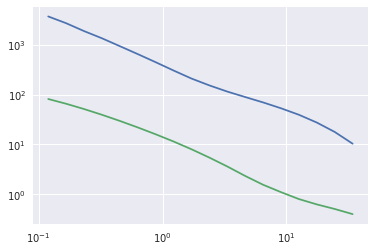

In [200]:
plt.plot(emu.scale_bin_centers, true_data[0])
plt.plot(emu.scale_bin_centers, true_data[1])

plt.loglog();

In [201]:
rbc = emu.scale_bin_centers#[-len(emu.scale_bin_centers):]

In [202]:
cov = f['cov'][()]
yerr = np.sqrt(np.diag(cov)).reshape((len(emus), -1))

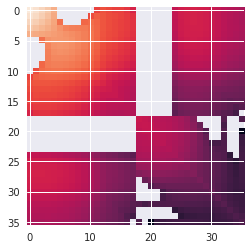

In [203]:
plt.imshow(np.log10(cov) )

In [204]:
(true_data[1]/(10**emus[1].emulate_wrt_r(true_param_dict).squeeze() ) )

array([1.1956151 , 1.08716302, 1.04211799, 1.02401454, 1.01507398,
       1.00866744, 1.00761061, 1.00951389, 1.01191236, 1.01588047,
       1.02225815, 1.00840324, 1.00564994, 1.02131384, 1.00799826,
       1.0332786 , 1.06668238, 1.07291589])

In [205]:
true_data

array([[3.67046115e+03, 2.68587097e+03, 1.86704547e+03, 1.33957041e+03,
        9.30848932e+02, 6.45761466e+02, 4.44257796e+02, 3.02746585e+02,
        2.09074584e+02, 1.52330606e+02, 1.14548962e+02, 8.90682088e+01,
        6.94674502e+01, 5.30164183e+01, 3.92803031e+01, 2.74329581e+01,
        1.77901804e+01, 1.03439673e+01],
       [8.12760963e+01, 6.53112366e+01, 5.11718897e+01, 3.92571969e+01,
        2.95591990e+01, 2.18952850e+01, 1.59647482e+01, 1.14391216e+01,
        7.99808271e+00, 5.44370980e+00, 3.61379155e+00, 2.33425032e+00,
        1.55491234e+00, 1.10505031e+00, 8.02946770e-01, 6.28019530e-01,
        5.08370232e-01, 4.01059480e-01]])

In [206]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.2,
 'w0': -1.0}

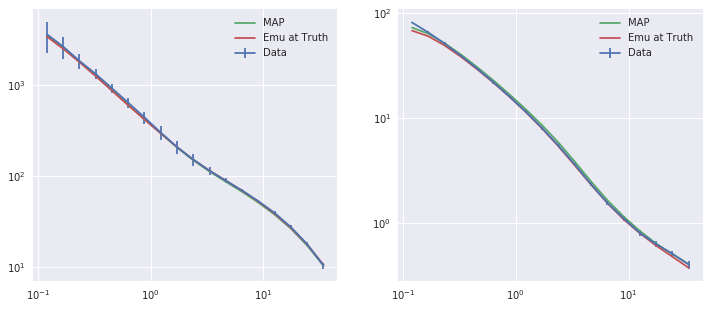

In [207]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, true_data[i], yerr=yerr[i], label = 'Data')
    plt.plot(rbc, 10**MAP_pred[i], label = 'MAP')
    plt.plot(rbc, 10**true_pred, label = 'Emu at Truth')

    plt.loglog()
    plt.legend(loc='best')
plt.show();

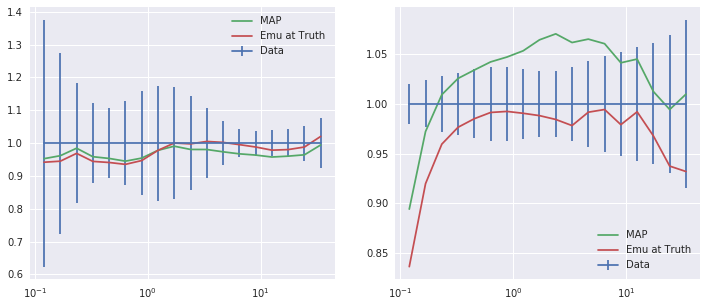

In [208]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    plt.plot(rbc, (10**MAP_pred[i])/true_data[i], label = 'MAP')
    plt.plot(rbc, (10**true_pred)/true_data[i], label = 'Emu at Truth')
    plt.legend(loc='best')
    plt.xscale('log')
plt.show();

In [209]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [210]:
npart_aemulus = 1400**3
npart_mdpl2 = 3840**3

downsample_factor = 1e-2
npart_aemulus_ds = npart_aemulus*downsample_factor
print npart_aemulus_ds, npart_aemulus_ds/npart_mdpl2

27440000.0 0.000484607837818


In [211]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [212]:
true_pred = np.hstack([emu.emulate_wrt_r(true_param_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
true_pred = true_pred.reshape((len(emus), -1))

In [213]:
rmin_idxs = rbc > rmin

In [214]:
cov_rmin_idxs = np.r_[rmin_idxs, rmin_idxs]

In [215]:
print 'True Red. Chi2'
R = (10**true_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

True Red. Chi2
0.3474922958782202


In [216]:
print 'Map Red. Chi2'
R = (10**MAP_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

Map Red. Chi2
1.0419945734026037


In [217]:
N = 10
cmap = sns.color_palette("BrBG_d", N)

In [218]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'logM1',
 'logM0',
 'sigma_logM',
 'alpha',
 'conc_gal_bias']

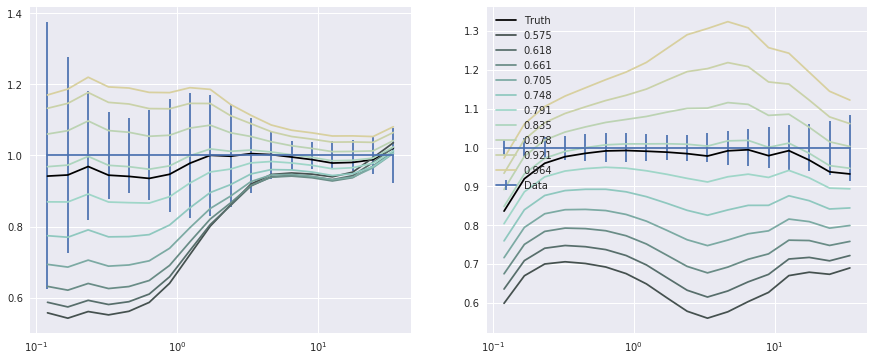

In [219]:
fig = plt.figure(figsize=(15,6))
varied_pname = 'sigma8'
lower, upper = emu.get_param_bounds(varied_pname)

for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.plot(rbc, (10**pred)/true_data[i], label = 'Truth', color = 'k')    

    plt.xscale('log')
    
for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    param_dict = true_param_dict.copy()
    param_dict[varied_pname] = val

    for i in xrange(len(emus)):
        plt.subplot(1,2,i+1)
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        plt.plot(rbc, (10**pred)/true_data[i], label = '%.3f'%val, color = c)
    
plt.legend(loc='best')
plt.show();

In [220]:
emu_avg = 10**(emus[1].y.mean(axis=(0,1))+emu._y_mean)

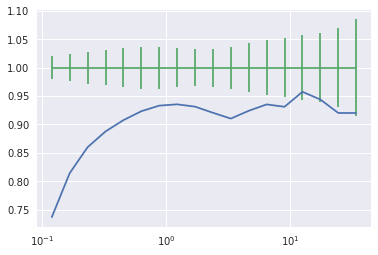

In [221]:
plt.plot(rbc, emu_avg/true_data[1])
plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i])
plt.xscale('log')